In [337]:
import matplotlib.pyplot as plt
import pandas as pd
import math
import random

from datetime import datetime
from datetime import timedelta

In [338]:
# store map size (pixels)
STORE_SIZE = [3136, 2475]

# re-id area size
RE_ID_ORIGIN_POINT = [1080, 1280]
RE_ID_AREA = [355, 690]

# Enter/Exit defined areas
# BL - Bottom Left / R - Right / T - Top / TL - Top Left
ENTER_EXIT_AREAS = {"BL":[1075, 1250, 1150, 1325], "R":[1400, 1250, 1435, 1960], "T":[1205, 1960, 1435, 1970], "TL":[1075, 1825, 1205, 1970]}

DISTANCE = 75
TIME_INTERVAL = 30

TRAJECTORY_DATA_SMALL_PATH = "results/trajectories/teste_dados_pequenos.csv"
TRAJECTORY_DATA_PATH = "results/trajectories/transformed_coords.csv"
MAP_PATH = "C:/Users/diogo/Desktop/Tese/Dados/floorplan.png"

In [339]:
# restrict the area of the points in the dataset
def get_data_reid_area(df):
    df_filtered = df[(df["x_floorplan_new"] >= RE_ID_ORIGIN_POINT[0]) & 
                     (df["x_floorplan_new"] <= RE_ID_ORIGIN_POINT[0] + RE_ID_AREA[0]) & 
                     (df["y_floorplan_new"] >= RE_ID_ORIGIN_POINT[1]) & 
                     (df["y_floorplan_new"] <= RE_ID_ORIGIN_POINT[1] + RE_ID_AREA[1])]
    return df_filtered


# returns the last point of each customer
def get_customers_last_point(df):
    for customer in df.customer_id_global.unique():
        all_except_last = df.loc[df["customer_id_global"] == customer].sort_values(by='time').iloc[:-1].index
        df = df.drop(all_except_last)
    return df


# returns the first point of each customer
def get_customers_first_point(df):
    for customer in df.customer_id_global.unique():
        all_except_first = df.loc[df["customer_id_global"] == customer].sort_values(by='time').iloc[1:].index
        df = df.drop(all_except_first)
    return df


# returns a boolean:
#       - True if the given point is inside a Exit/Entry area
#       - False otherwise
def is_in_EE_area(x, y):
    areas = ["BL", "R", "T", "TL"]
    for area in areas:
        if (ENTER_EXIT_AREAS[area][0] < x < ENTER_EXIT_AREAS[area][2]) and (ENTER_EXIT_AREAS[area][1] < y < ENTER_EXIT_AREAS[area][3]):
            return True
    return False


# return the eligible points based on their location
def get_eligible_points(df):
    for index, row in df.iterrows():
        if is_in_EE_area(row["x_floorplan_new"], row["y_floorplan_new"]):
            df = df.drop(index)
    return df


# return points in a given time interval
def get_similar_time_points(df, time, time_interval):
    begin_time = str((datetime.strptime(time,"%H:%M:%S") - timedelta(seconds=time_interval)).time())
    end_time = str((datetime.strptime(time,"%H:%M:%S") + timedelta(seconds=time_interval)).time())
    return df.loc[(df["time"] > begin_time) & (df["time"] < end_time)]


# return the closest point to the last customer point
# note: this is applied after filter points by time
def get_closest_customer(df, x, y, max_dist):
    closest_customer = pd.DataFrame()
    for index, row in df.iterrows():
        distance = math.dist((x, y), (row["x_floorplan_new"], row["y_floorplan_new"]))
        if distance < max_dist:
            if closest_customer.empty or distance < math.dist((x, y), (closest_customer["x_floorplan_new"], closest_customer["y_floorplan_new"])):
                closest_customer = row
    return closest_customer
    

def re_id_customers(df, first_points, last_points, distance, time_interval):
    #first_points = get_eligible_points(get_customers_first_point(df))
    #last_points = get_eligible_points(get_customers_last_point(df))
    first_points["need_reid"] = "yes"
    for index, row in last_points.iterrows():
        first_points_without_self = first_points.loc[first_points["customer_id_global"] != row["customer_id_global"]]
        first_points_need_reid = first_points_without_self.loc[first_points_without_self["need_reid"] == "yes"]
        if not first_points_need_reid.empty:
            similiar_time = get_similar_time_points(first_points_need_reid, row["time"], time_interval)
            if not similiar_time.empty:
                customer_to_reid = get_closest_customer(similiar_time, row["x_floorplan_new"], row["y_floorplan_new"], distance)
                if not customer_to_reid.empty:
                    df.loc[df["customer_id_global"] == customer_to_reid.customer_id_global, "customer_reid"] = row["customer_id_global"]
                    first_points.loc[first_points["customer_id_global"] == customer_to_reid["customer_id_global"], "need_reid"] = "no"
                    if not math.isnan(df.loc[index]["customer_reid"]):
                        df.loc[df["customer_id_global"] == customer_to_reid.customer_id_global, "customer_reid"] = df.loc[index]["customer_reid"]

    df.loc[df['customer_reid'].isna(), "customer_reid"] = df["customer_id_global"]
    return df


def random_color():
    r = random.randint(0, 255)
    g = random.randint(0, 255)
    b = random.randint(0, 255)
    return f"#{r:02x}{g:02x}{b:02x}"


# paint the trajectory points in the store plant
def print_trajectory(df):
    img = plt.imread(MAP_PATH)
    fig, ax = plt.subplots()
    fig.set_dpi(1200)
    ax.imshow(img, extent=[0, STORE_SIZE[0], 0, STORE_SIZE[1]])
    for customer in df["customer_reid"].unique():
        customer_df = df[df["customer_reid"] == customer]
        color = random_color()
        plt.scatter(customer_df["x_floorplan_new"], customer_df["y_floorplan_new"], marker=".", s=1, lw=0, color=color)

In [340]:
df = pd.read_csv(TRAJECTORY_DATA_SMALL_PATH, low_memory=False, index_col=None, header=0)
df_filtered = get_data_reid_area(df)
first_points = get_customers_first_point(df_filtered)
last_points = get_customers_last_point(df_filtered)
eligible_first_points = get_eligible_points(get_customers_first_point(df_filtered)).sort_values(by="camera")
eligible_last_points = get_eligible_points(get_customers_last_point(df_filtered)).sort_values(by="camera")

                      video_name  frame_id        xmin        ymin  \
0    20220314_1.03_12_16_blurred       365  188.947007  504.249694   
1    20220314_1.03_12_16_blurred       365  653.248873  232.429533   
2    20220314_1.03_12_16_blurred       365  275.768984  507.913945   
3    20220314_1.03_12_16_blurred       365  213.373203  336.713356   
61     20220314_1.04_5_6_blurred        13  323.338454  639.156128   
107    20220314_1.04_5_6_blurred        20  196.696626  532.502344   
116    20220314_1.04_5_6_blurred        26  276.195100  369.623978   
16    20220314_2.05_4_51_blurred       674  338.165012   76.439196   
185   20220314_2.05_4_52_blurred         6  375.483289   79.667169   

           xmax        ymax  velocity  customer_id  x_floorplan  y_floorplan  \
0    316.821741  624.069191     1.372         1188  -363.744361   -49.881306   
1    733.333256  331.515314     0.024         1192  -359.602319   -48.181909   
2    382.832524  596.773662     1.387         1191  -363.24

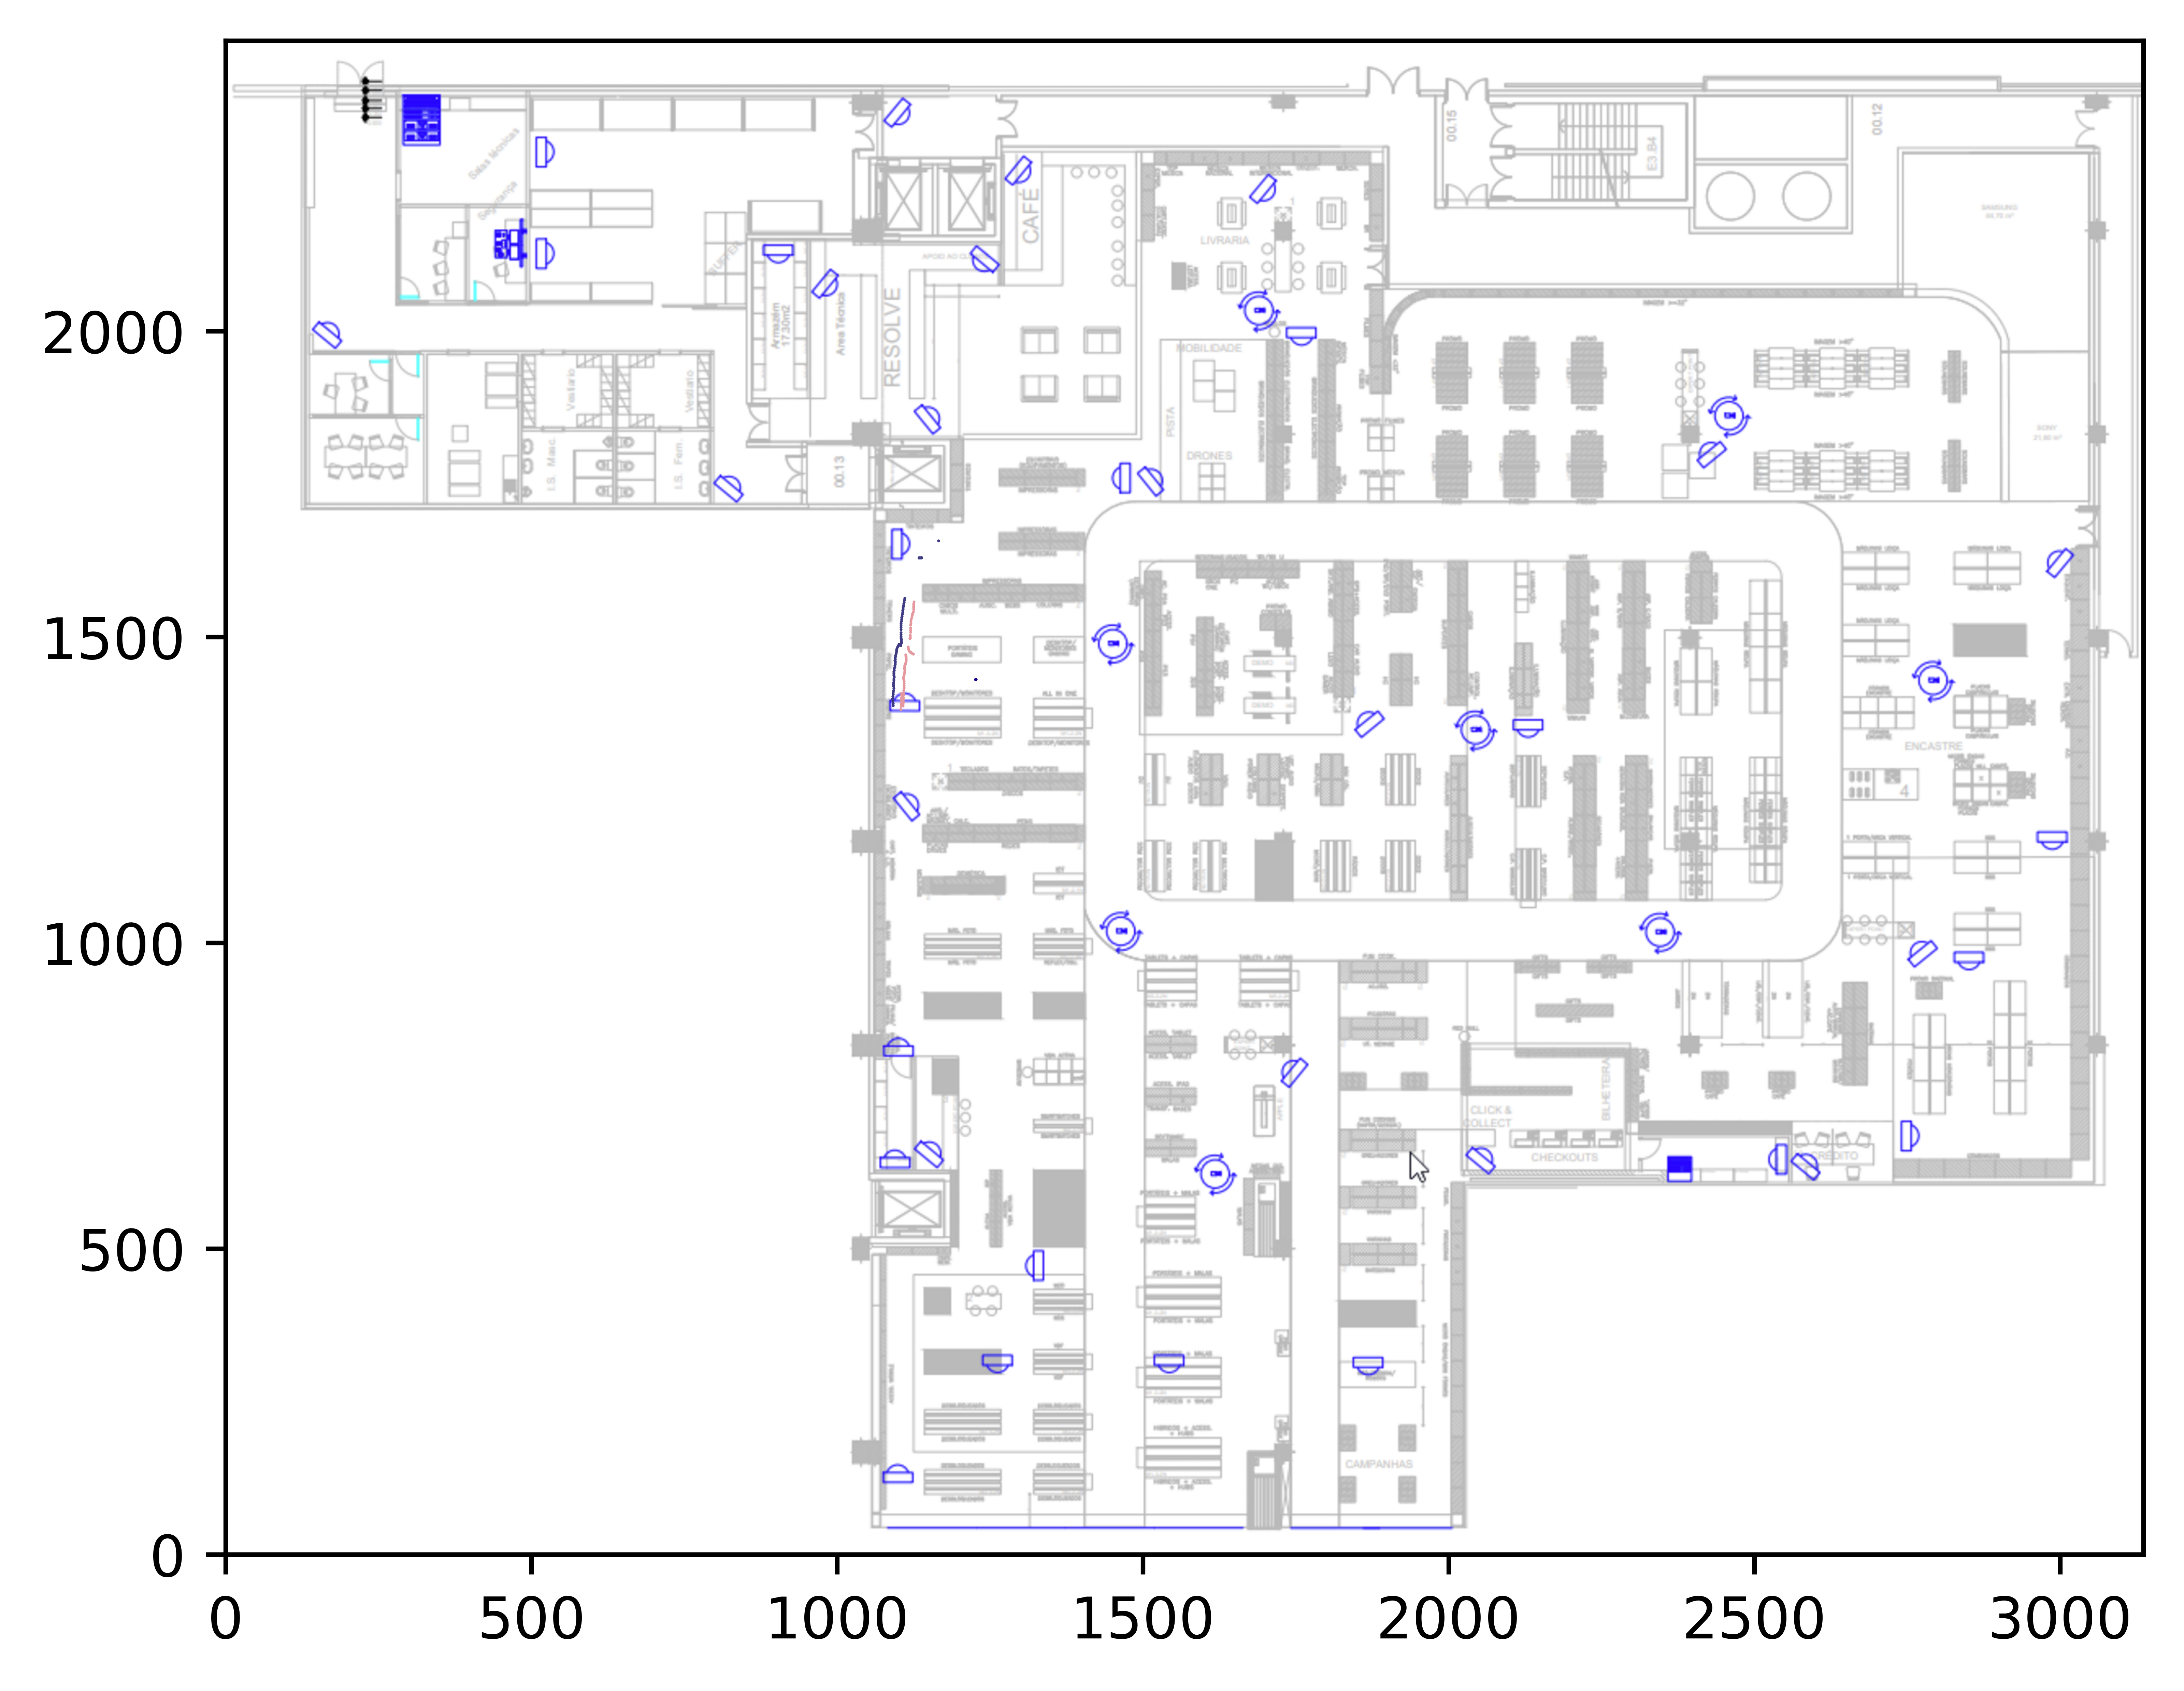

In [341]:
re_id_customers(df_filtered, eligible_first_points, eligible_last_points, DISTANCE, TIME_INTERVAL)
df_filtered.to_csv("results/trajectories/data_reid_area.csv", index=False)
print_trajectory(df_filtered)

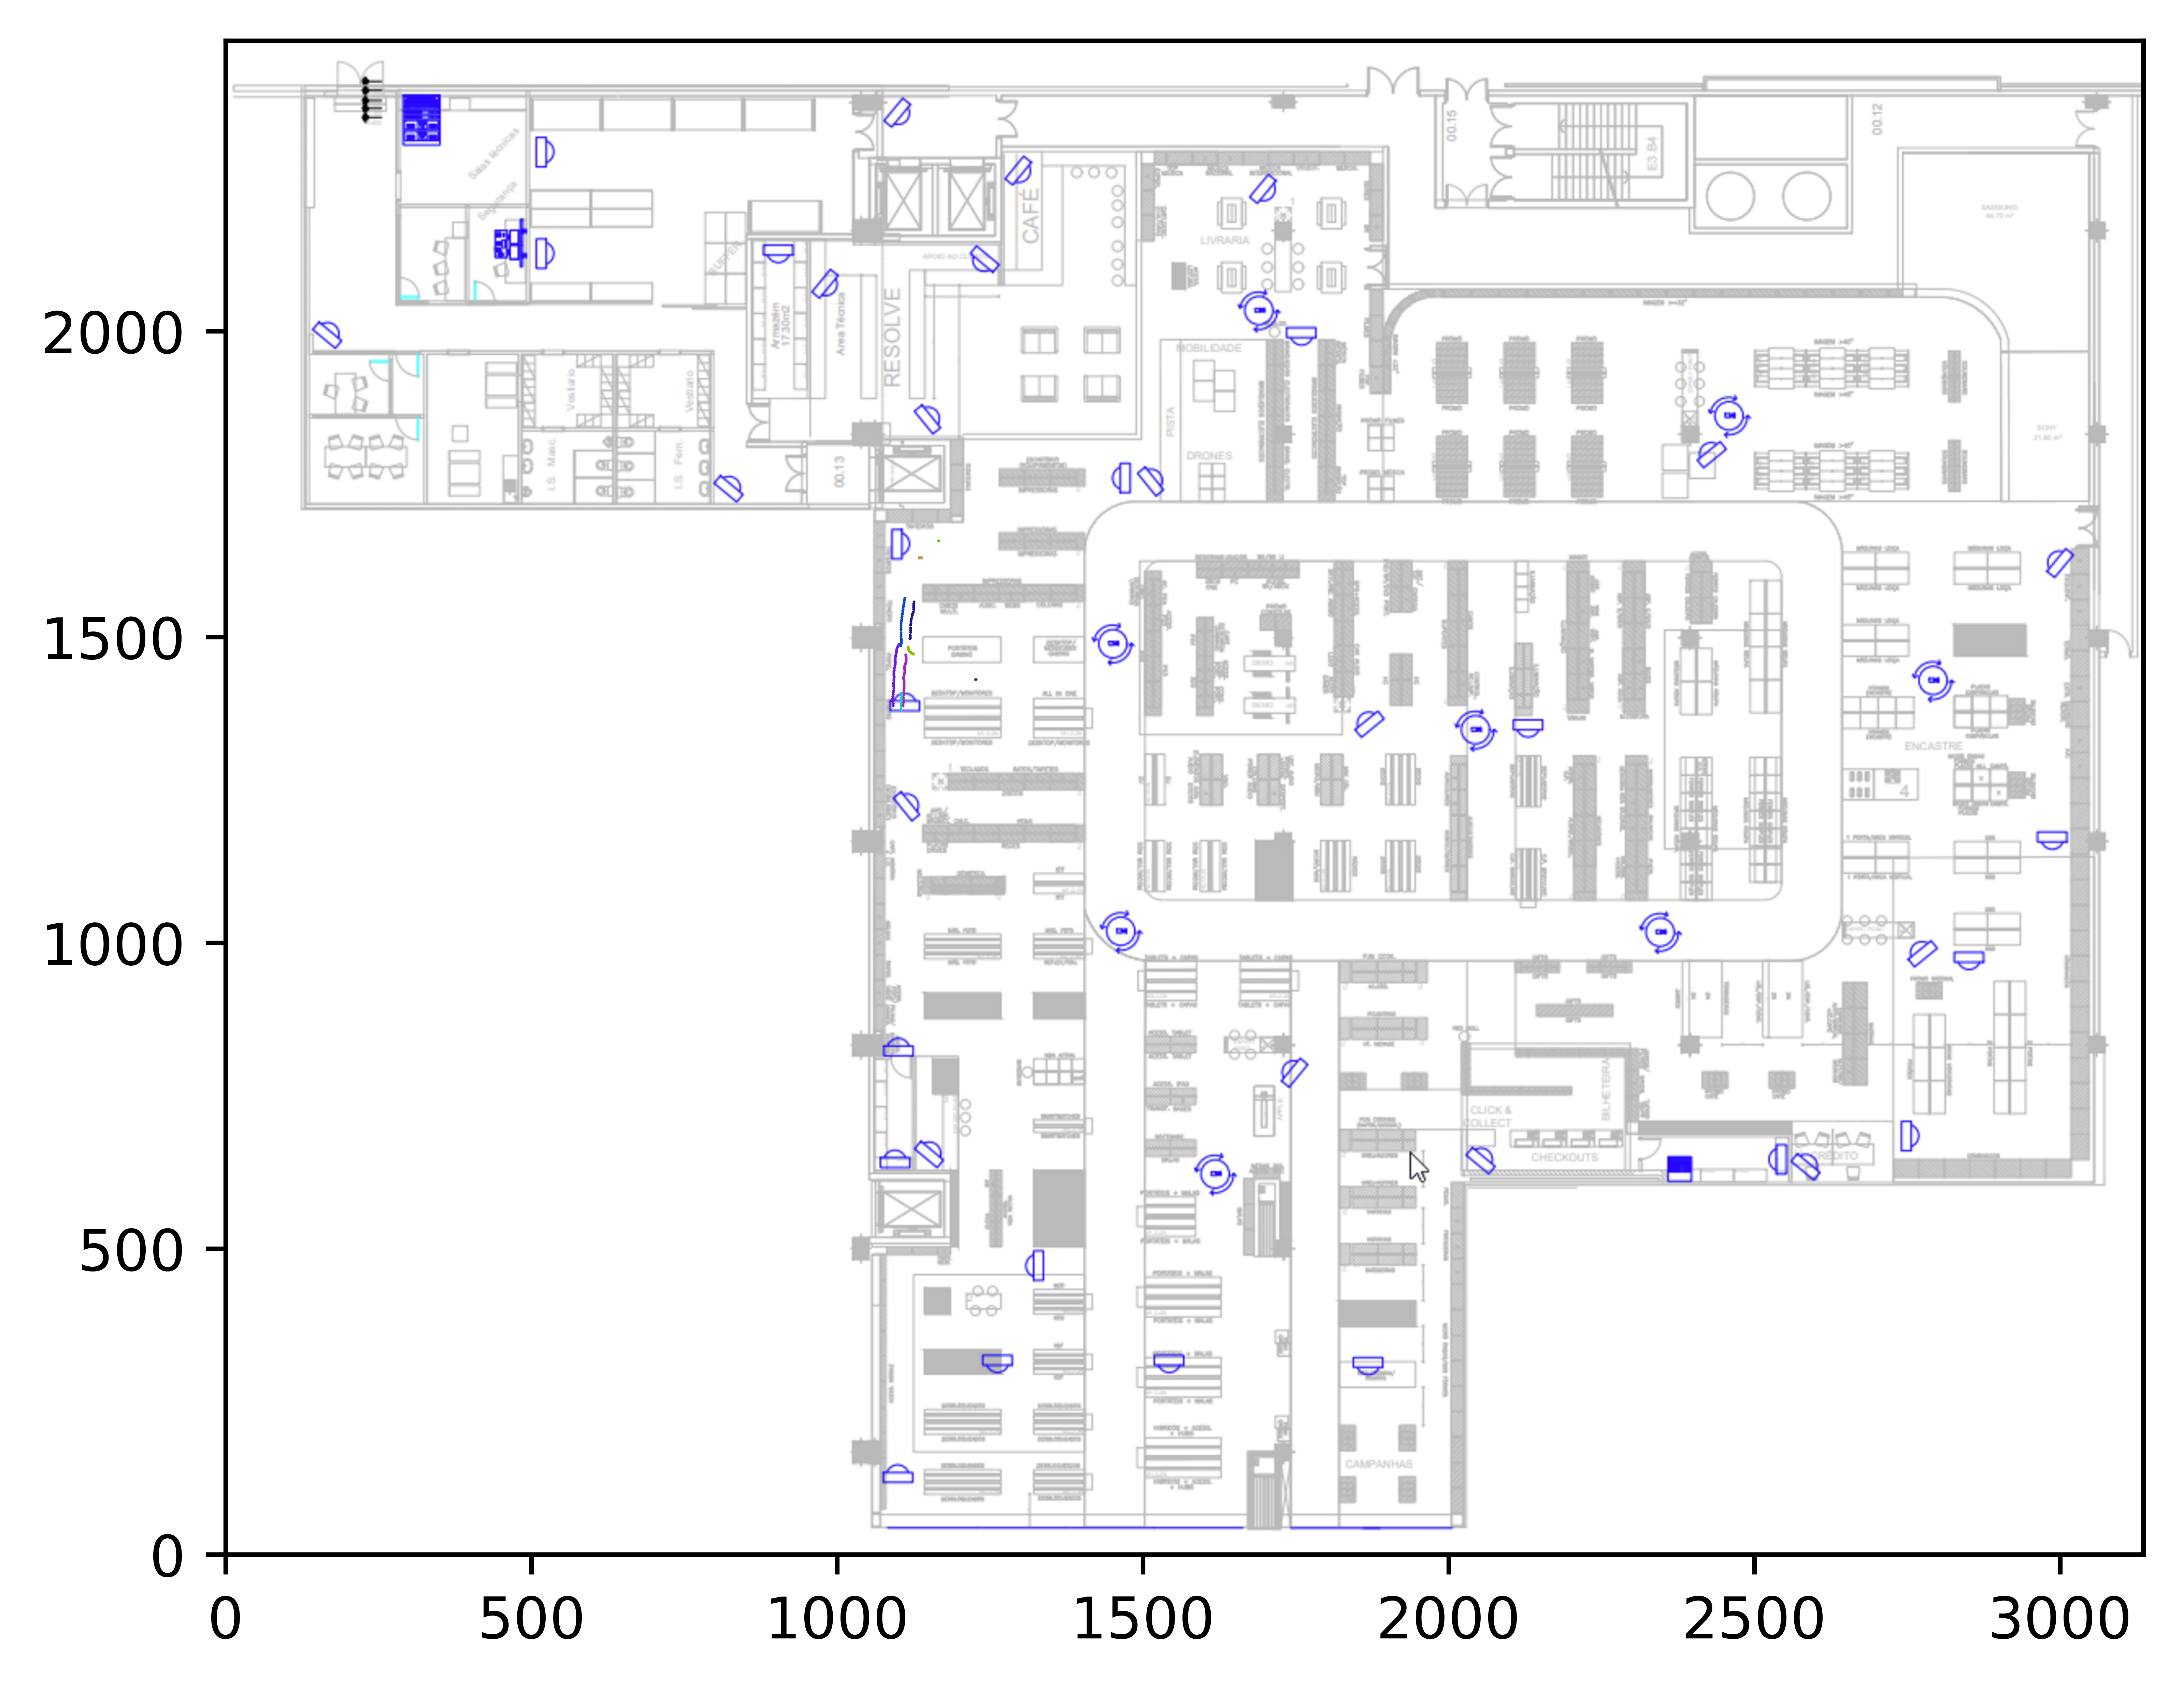

In [342]:
# paint the trajectory points in the store plant
def other_print_trajectory(df):
    img = plt.imread(MAP_PATH)
    fig, ax = plt.subplots()
    fig.set_dpi(1200)
    ax.imshow(img, extent=[0, STORE_SIZE[0], 0, STORE_SIZE[1]])
    for customer in df["customer_id_global"].unique():
        customer_df = df[df["customer_id_global"] == customer]
        color = random_color()
        plt.scatter(customer_df["x_floorplan_new"], customer_df["y_floorplan_new"], marker=".", s=1, lw=0, color=color)


other_print_trajectory(df)